<a href="https://colab.research.google.com/github/Divyaanshvats/FIDROX_ASSIGNMENTS/blob/main/FIDROX_K_MEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AccessAI: Detecting Anomalous Swipe Behavior in Physical Access Control Systems**

# **IMPORT ALL THE REQUIRE LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os
np.random.seed(42)
random.seed(42)
NUM_DAYS = 30
SWIPES_PER_DAY = 1000
TOTAL_RECORDS = NUM_DAYS * SWIPES_PER_DAY
user_ids = [f"U{str(i).zfill(3)}" for i in range(1, 101)]
doors = {
    "D01": "Main Entrance",
    "D02": "East Wing",
    "D03": "Server Room",# restricted
    "D04": "HR Department",
    "D05": "Rooftop Access",# rarely used
    "D06": "Finance Room",
    "D07": "Cafeteria",
    "D08": "Basement Storage",# rarely used
}

# **RANDOM GENERATION OF DATASET(SAME AS DBSCAN)**

In [2]:
data = []
start_date = datetime(2025, 5, 1)
for i in range(TOTAL_RECORDS):
    current_date = start_date + timedelta(days=i // SWIPES_PER_DAY)
    if np.random.rand() < 0.8:
        hour = np.random.randint(8, 19)
    else:
        hour = np.random.choice([0, 1, 2, 3, 4, 22, 23])

    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    timestamp = current_date.replace(hour=hour, minute=minute, second=second)
    user = random.choice(user_ids)
    door = random.choices(list(doors.keys()), weights=[25, 20, 5, 15, 2, 10, 20, 3])[0]
    direction = random.choice(["IN", "OUT"])
    result = "Success" if np.random.rand() > 0.05 else "Failed"
    if np.random.rand() < 0.01:
        for _ in range(5):
            anomaly_timestamp = timestamp + timedelta(seconds=random.randint(1, 30))
            data.append([anomaly_timestamp, user, door, doors[door], direction, "Failed"])

    data.append([timestamp, user, door, doors[door], direction, result])
df = pd.DataFrame(data, columns=["Timestamp", "UserID", "DoorID", "DoorName", "Direction", "Result"])
df.head()

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success


In [3]:
output_path = "/mnt/data/AccessAI_Simulated_Swipe_Logs.csv"
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(output_path, index=False)
output_path

'/mnt/data/AccessAI_Simulated_Swipe_Logs.csv'

In [4]:
df = pd.read_csv("/mnt/data/AccessAI_Simulated_Swipe_Logs.csv")
df.head(6)

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success
5,2025-05-01 23:20:08,U072,D01,Main Entrance,OUT,Success


# **DATA ANALYSIS(Basic Analysis)**

In [5]:
len(df)#length of dataset

31505

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31505 entries, 0 to 31504
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  31505 non-null  object
 1   UserID     31505 non-null  object
 2   DoorID     31505 non-null  object
 3   DoorName   31505 non-null  object
 4   Direction  31505 non-null  object
 5   Result     31505 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [7]:
df.isnull().sum()

,0
Timestamp,0
UserID,0
DoorID,0
DoorName,0
Direction,0
Result,0


In [8]:
df['UserID'].value_counts().head()

,count
UserID,
U089,411
U017,373
U001,359
U054,352
U018,348


In [9]:
df['DoorName'].value_counts()

,count
DoorName,
Main Entrance,7837
Cafeteria,6296
East Wing,6286
HR Department,4778
Finance Room,3200
Server Room,1567
Basement Storage,896
Rooftop Access,645


In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.day_name()

In [15]:
failure_rate = df['Result'].value_counts(normalize=True)['Failed']
failures_by_door = df[df['Result'] == 'Failed']['DoorName'].value_counts()
failures_by_hour = df[df['Result'] == 'Failed']['Hour'].value_counts().sort_index()

In [16]:
df['DirectionCode'] = df['Direction'].map({'IN': 0, 'OUT': 1})
df['ResultCode'] = df['Result'].map({'Success': 0, 'Failed': 1})
df['DoorCode'] = df['DoorID'].astype('category').cat.codes
df['UserCode'] = df['UserID'].astype('category').cat.codes
features = df[['Hour', 'DirectionCode', 'ResultCode', 'DoorCode', 'UserCode']]

In [18]:
restricted_doors = ['D03', 'D05', 'D08']
rare_restricted_anomalies = df[df['DoorID'].isin(restricted_doors)]
print(f"Anomalies for rarely used or restricted doors: {len(rare_restricted_anomalies)}")

Anomalies for rarely used or restricted doors: 3108


In [19]:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
odd_hours = [0, 1, 2, 3, 4, 22, 23]
odd_hour_anomalies = df[df['Hour'].isin(odd_hours)]
print(f"Anomalies for odd hours: {len(odd_hour_anomalies)}")

Anomalies for odd hours: 6261


In [20]:
failed_swipes = df[df['Result'] == 'Failed']
failed_by_user = failed_swipes.groupby('UserID').size()
high_failure_threshold = 5
high_failure_anomalies = failed_by_user[failed_by_user > high_failure_threshold]
print(f"Users with high failed attempts: {len(high_failure_anomalies)}")

Users with high failed attempts: 100


In [21]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(['UserID', 'DoorID', 'Timestamp'])
df_sorted['TimeDiff'] = df_sorted.groupby(['UserID', 'DoorID'])['Timestamp'].diff().dt.total_seconds()
rapid_swipes = df_sorted[(df_sorted['TimeDiff'].notnull()) & (df_sorted['TimeDiff'] <= 30)]
print(f"Rapid sequential swipe anomalies: {len(rapid_swipes)}")

Rapid sequential swipe anomalies: 1541


In [23]:
df['IsRestrictedDoor'] = df['DoorID'].isin(['D03', 'D05', 'D08']).astype(int)
df['IsOddHour'] = df['Hour'].isin([0, 1, 2, 3, 4, 22, 23]).astype(int)
df['IsFailed'] = (df['Result'] == 'Failed').astype(int)
df_sorted['TimeDiff'] = df_sorted.groupby(['UserID', 'DoorID'])['Timestamp'].diff().dt.total_seconds().fillna(9999)
numeric_features = df[['IsRestrictedDoor', 'IsOddHour', 'IsFailed', 'Hour']].copy()
numeric_features['TimeDiff'] = df_sorted['TimeDiff']
z_scores = np.abs((numeric_features - numeric_features.mean()) / numeric_features.std())
z_anomalies = (z_scores > 2).any(axis=1)
print(f"Improved Z-score anomalies: {z_anomalies.sum()}")

Improved Z-score anomalies: 11126


# **K-MEANS CLUSTERING METHOD**

In [24]:
features_kmeans = df[['Hour', 'IsRestrictedDoor', 'IsOddHour', 'IsFailed']]

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_kmeans)

# **ELBOW METHOD FOR OPTIMAL K**

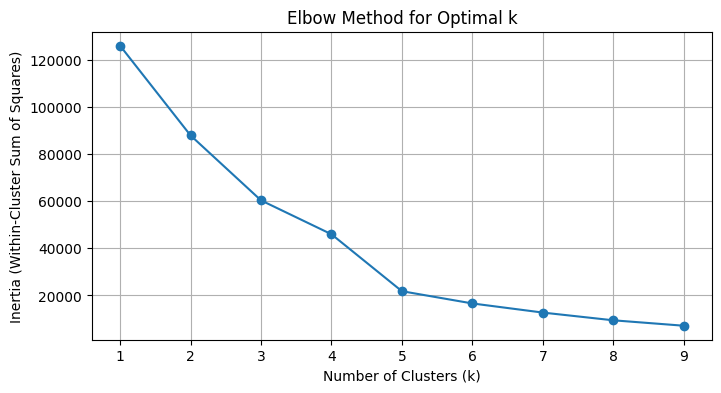

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Try different values of k
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

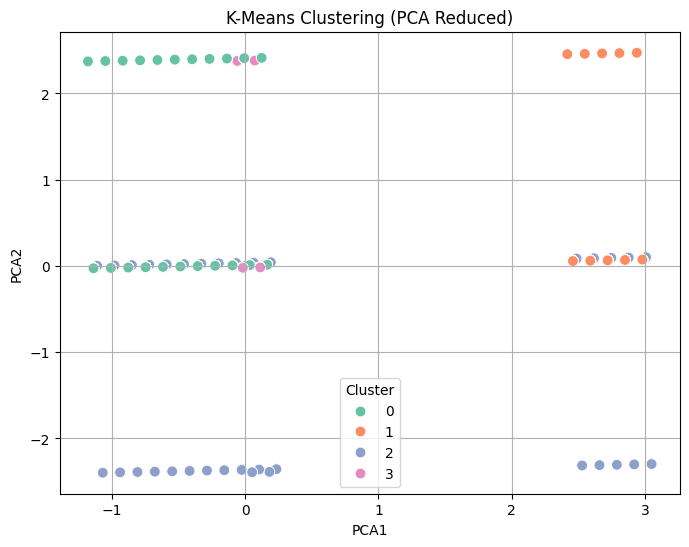

In [28]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('K-Means Clustering (PCA Reduced)')
plt.grid(True)
plt.show()

In [29]:
import numpy as np
# Calculate z-scores
df['Z_Hour'] = np.abs((df['Hour'] - df['Hour'].mean()) / df['Hour'].std())
df['Z_Failed'] = np.abs((df['IsFailed'] - df['IsFailed'].mean()) / df['IsFailed'].std())
df['Anomaly_Z'] = ((df['Z_Hour'] > 3) | (df['Z_Failed'] > 3)).astype(int)

In [30]:
# Number of Z-score anomalies
print("Z-score based anomalies found:", df['Anomaly_Z'].sum())
df[df['Anomaly_Z'] == 1].head(3)

Z-score based anomalies found: 3027


,Timestamp,UserID,DoorID,DoorName,Direction,Result,ResultCode,DoorCode,UserCode,DirectionCode,...,DayOfWeek,IsRestrictedDoor,IsOddHour,IsFailed,Cluster,PCA1,PCA2,Z_Hour,Z_Failed,Anomaly_Z
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed,1,1,75,0,...,Thursday,0,0,1,0,-1.048675,2.376289,0.922625,3.067197,1
6,2025-05-01 01:57:08,U029,D02,East Wing,OUT,Failed,1,1,28,1,...,Thursday,0,1,1,1,2.807613,2.468609,2.026593,3.067197,1
7,2025-05-01 14:43:07,U001,D06,Finance Room,IN,Failed,1,5,0,0,...,Thursday,0,0,1,0,-0.657825,2.388676,0.369647,3.067197,1


In [31]:
def detect_iqr_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ~df[col].between(lower_bound, upper_bound)
df['Anomaly_IQR'] = (
    detect_iqr_outliers('Hour') |
    detect_iqr_outliers('IsFailed') |
    detect_iqr_outliers('IsRestrictedDoor')
).astype(int)

In [32]:
# Number of IQR anomalies
print("IQR based anomalies found:", df['Anomaly_IQR'].sum())
df[df['Anomaly_IQR'] == 1].head(3)

IQR based anomalies found: 5889


,Timestamp,UserID,DoorID,DoorName,Direction,Result,ResultCode,DoorCode,UserCode,DirectionCode,...,IsRestrictedDoor,IsOddHour,IsFailed,Cluster,PCA1,PCA2,Z_Hour,Z_Failed,Anomaly_Z,Anomaly_IQR
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed,1,1,75,0,...,0,0,1,0,-1.048675,2.376289,0.922625,3.067197,1,1
6,2025-05-01 01:57:08,U029,D02,East Wing,OUT,Failed,1,1,28,1,...,0,1,1,1,2.807613,2.468609,2.026593,3.067197,1,1
7,2025-05-01 14:43:07,U001,D06,Finance Room,IN,Failed,1,5,0,0,...,0,0,1,0,-0.657825,2.388676,0.369647,3.067197,1,1


In [33]:
def detect_iqr_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ~df[col].between(lower_bound, upper_bound)
df['Anomaly_IQR'] = (
    detect_iqr_outliers('Hour') |
    detect_iqr_outliers('IsFailed') |
    detect_iqr_outliers('IsRestrictedDoor')
).astype(int)
print("Total IQR Anomalies Detected:", df['Anomaly_IQR'].sum())

Total IQR Anomalies Detected: 5889


# **VISULAIZATION**

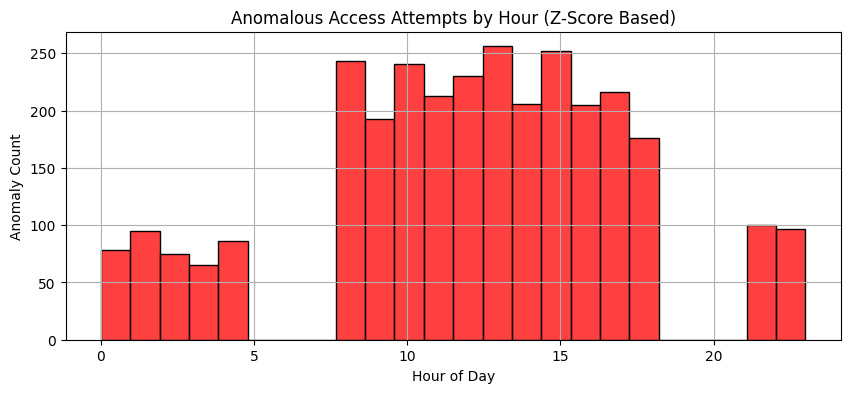

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
sns.histplot(data=df[df['Anomaly_Z'] == 1], x='Hour', bins=24, kde=False, color='red')
plt.title('Anomalous Access Attempts by Hour (Z-Score Based)')
plt.xlabel('Hour of Day')
plt.ylabel('Anomaly Count')
plt.grid(True)
plt.show()

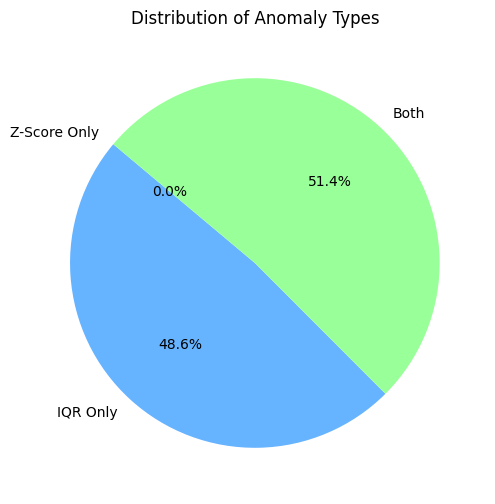

In [35]:
labels = ['Z-Score Only', 'IQR Only', 'Both']
counts = [
    ((df['Anomaly_Z'] == 1) & (df['Anomaly_IQR'] == 0)).sum(),
    ((df['Anomaly_Z'] == 0) & (df['Anomaly_IQR'] == 1)).sum(),
    ((df['Anomaly_Z'] == 1) & (df['Anomaly_IQR'] == 1)).sum()
]
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Anomaly Types')
plt.show()

# **Step-by-Step K-Means Code**

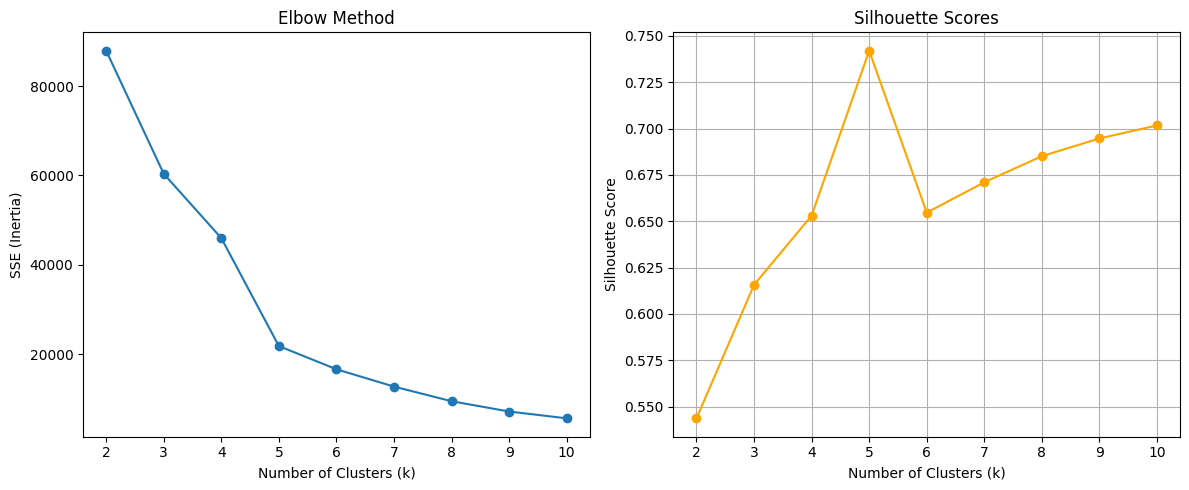

✅ Best k: 5 with Silhouette Score: 0.742


In [36]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
### 1. Elbow Method to Choose Optimal K ###
sse = []
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow + Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'o-', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.grid(True)
plt.show()
best_k = k_range[np.argmax(sil_scores)]
print(f"✅ Best k: {best_k} with Silhouette Score: {max(sil_scores):.3f}")
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

# **PCA Scatter Plot for K-Means**

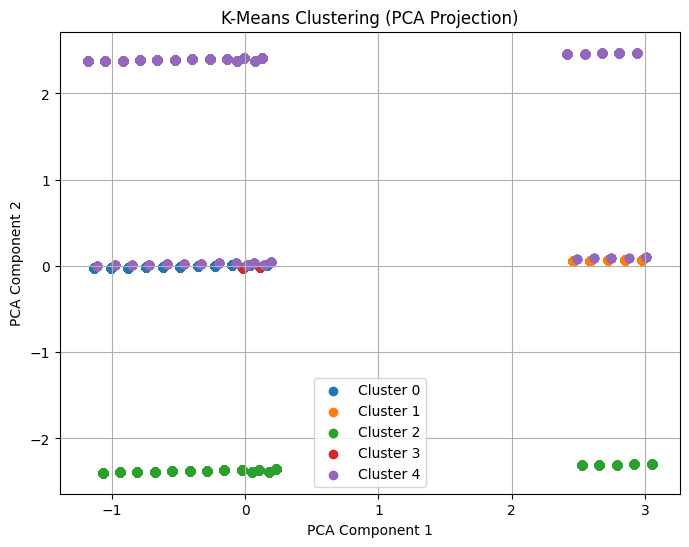

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
for i in range(best_k):
    cluster = X_pca[labels_kmeans == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# **Bar Chart: Failed Attempts per Door**

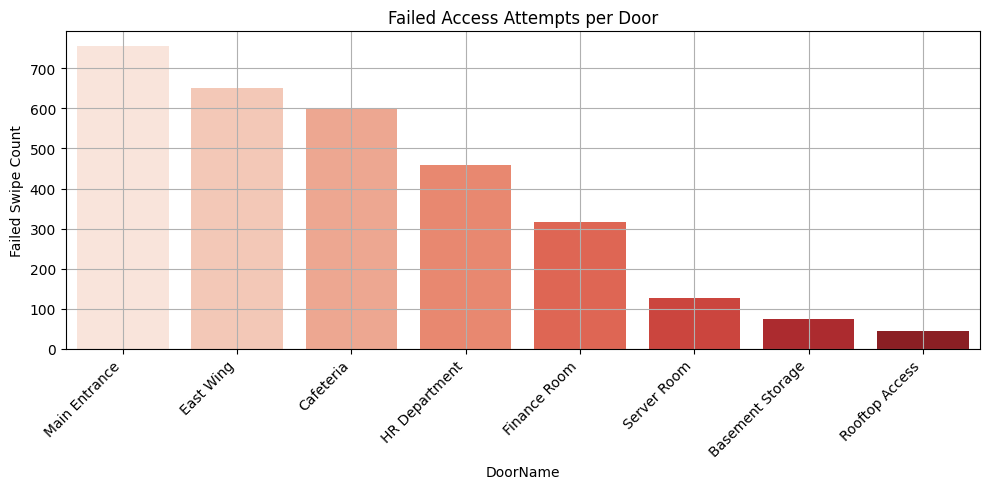

In [38]:
failed = df[df['Result'] == 'Failed']
failed_count = failed['DoorName'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=failed_count.index, y=failed_count.values, palette='Reds')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Failed Swipe Count")
plt.title("Failed Access Attempts per Door")
plt.tight_layout()
plt.grid(True)
plt.show()

# **Heatmap: Swipe Result by Door vs. Hour**

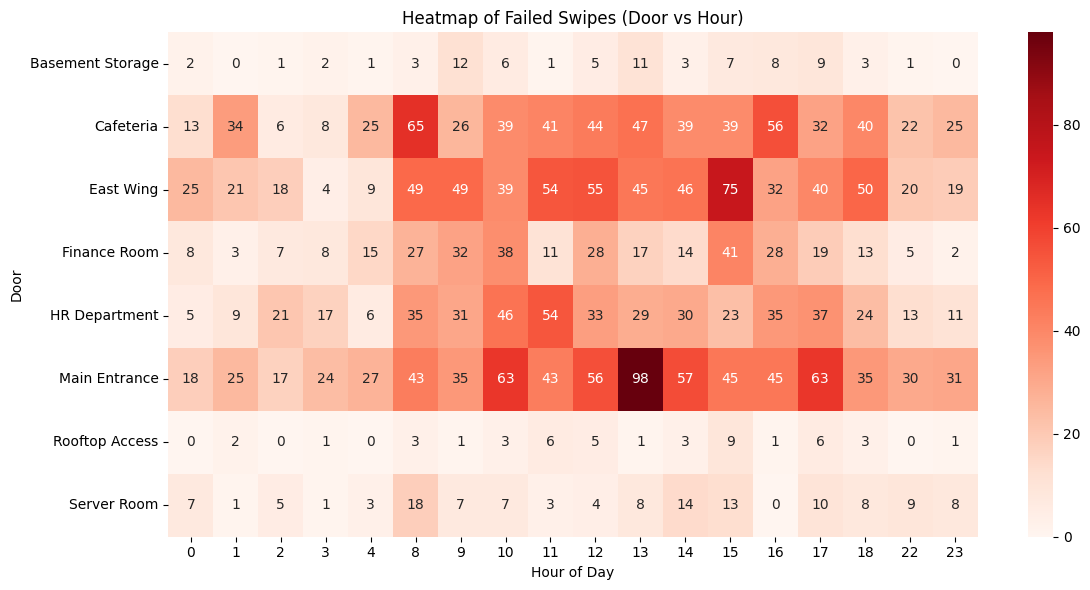

In [39]:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
heatmap_data = df[df['Result'] == 'Failed'].groupby(['DoorName', 'Hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title("Heatmap of Failed Swipes (Door vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Door")
plt.tight_layout()
plt.show()

# **Silhouette Score for Final KMeans**

In [40]:
final_score = silhouette_score(X_scaled, labels_kmeans)
print(f"✅ Final K-Means Silhouette Score: {final_score:.3f}")

✅ Final K-Means Silhouette Score: 0.742


# **Anomaly Scoring with K-Means (like DBSCAN)**

In [41]:
distances = np.linalg.norm(X_scaled - kmeans_final.cluster_centers_[labels_kmeans], axis=1)
df['KMeans_Cluster'] = labels_kmeans
df['KMeans_AnomalyScore'] = distances
threshold = np.percentile(distances, 95)
df['KMeans_Anomaly'] = df['KMeans_AnomalyScore'] > threshold
print(f"✅ Flagged {df['KMeans_Anomaly'].sum()} anomalous entries using KMeans.")

✅ Flagged 1406 anomalous entries using KMeans.


In [42]:
df.sort_values(by='KMeans_AnomalyScore', ascending=False).head(10)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,ResultCode,DoorCode,UserCode,DirectionCode,...,Cluster,PCA1,PCA2,Z_Hour,Z_Failed,Anomaly_Z,Anomaly_IQR,KMeans_Cluster,KMeans_AnomalyScore,KMeans_Anomaly
17000,2025-05-17 00:38:40,U083,D03,Server Room,IN,Failed,1,2,82,0,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
19712,2025-05-19 00:13:25,U063,D03,Server Room,OUT,Failed,1,2,62,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
19067,2025-05-19 00:41:52,U004,D08,Basement Storage,IN,Failed,1,7,3,0,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
10507,2025-05-10 00:35:48,U089,D03,Server Room,OUT,Failed,1,2,88,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
10506,2025-05-10 00:35:39,U089,D03,Server Room,OUT,Failed,1,2,88,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
10508,2025-05-10 00:35:44,U089,D03,Server Room,OUT,Failed,1,2,88,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
10505,2025-05-10 00:36:06,U089,D03,Server Room,OUT,Failed,1,2,88,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
16502,2025-05-16 00:14:45,U011,D08,Basement Storage,OUT,Failed,1,7,10,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
10504,2025-05-10 00:36:02,U089,D03,Server Room,OUT,Failed,1,2,88,1,...,2,3.006999,0.102287,2.210919,3.067197,1,1,4,4.299874,True
28242,2025-05-27 01:58:06,U064,D05,Rooftop Access,IN,Failed,1,4,63,0,...,2,2.876716,0.098159,2.026593,3.067197,1,1,4,4.207496,True


# **Cluster-Level Summaries**

In [43]:
# Cluster summary
cluster_summary = df.groupby('KMeans_Cluster').agg(
    Cluster_Size=('UserID', 'count'),
    Failed_Swipes=('Result', lambda x: (x == 'Failed').sum()),
    Anomalies=('KMeans_Anomaly', 'sum')
)
cluster_summary['Failure_Rate'] = cluster_summary['Failed_Swipes'] / cluster_summary['Cluster_Size']
cluster_summary['Anomaly_Rate'] = cluster_summary['Anomalies'] / cluster_summary['Cluster_Size']
print(cluster_summary.sort_values(by='Anomaly_Rate', ascending=False))

                Cluster_Size  Failed_Swipes  Anomalies  Failure_Rate  \
KMeans_Cluster                                                         
4                       3027           3027        797           1.0   
2                       2862              0        609           0.0   
0                      20560              0          0           0.0   
1                       3586              0          0           0.0   
3                       1470              0          0           0.0   

                Anomaly_Rate  
KMeans_Cluster                
4                   0.263297  
2                   0.212788  
0                   0.000000  
1                   0.000000  
3                   0.000000  


# **Cluster Failure & Anomaly Rate Bar Plot**

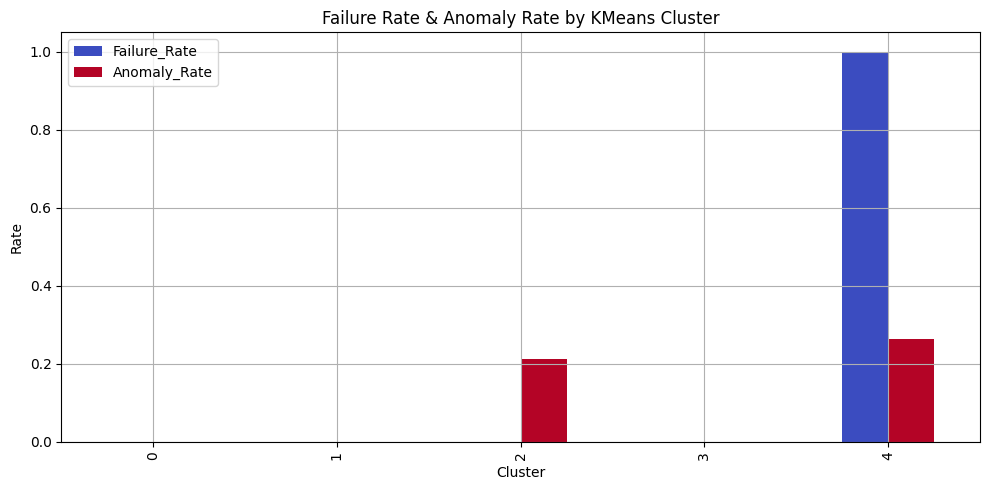

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 5))
cluster_summary[['Failure_Rate', 'Anomaly_Rate']].plot(kind='bar', ax=ax1, colormap='coolwarm')
plt.title("Failure Rate & Anomaly Rate by KMeans Cluster")
plt.xlabel("Cluster")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()